In [14]:
!pip install matplotlib seaborn wordcloud

     |████████████████████████████████| 371 kB 21.9 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import gc
import sys
from pathlib import Path
sys.path.insert(0, '/src')

from utils.database import DbEngine
from utils.load_data import DataLoader, PatientCensus
from datetime import timedelta
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from pylab import *
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
import os

CLIENT = 'trio'
START_DATE, END_DATE = pd.to_datetime('2020-01-01'), pd.to_datetime('2021-05-18')

print(CLIENT)
print(os.environ.get('SAIVA_ENV','dev'))
print(START_DATE, END_DATE)

trio
dev
2020-01-01 00:00:00 2021-05-18 00:00:00


In [3]:
engine = DbEngine()
saiva_engine = engine.get_postgresdb_engine()
client_sql_engine = engine.get_sqldb_engine(clientdb_name=CLIENT)


In [4]:
# verify connectivity
engine.verify_connectivity(client_sql_engine)

### Load patient data

In [5]:
census = PatientCensus(
    client_sql_engine=client_sql_engine, 
    start_date=START_DATE, 
    end_date=END_DATE
)
df = census.get_patient_census()
masterpatient_ids = df['masterpatientid']

In [6]:
data = DataLoader(
    client_sql_engine=client_sql_engine, 
    masterpatientid_list=masterpatient_ids, 
    census_date=END_DATE
)

notes_df = data.load_notes()


Notes : (3754099, 7)


In [7]:
transfered_masterpatientid = df[df['transfered'] == True].masterpatientid.unique()
safe_masterpatientid = df[df['transfered'] == False].masterpatientid.unique()

print(len(transfered_masterpatientid))
print(len(safe_masterpatientid))

367
3563


In [8]:
transfered_notes = notes_df[notes_df['masterpatientid'].isin(transfered_masterpatientid)]
safe_notes = notes_df[notes_df['masterpatientid'].isin(safe_masterpatientid)]

print(transfered_notes.shape)
print(safe_notes.shape)

(706119, 7)
(3754099, 7)


## Preprocess the progress notes

In [9]:
import string
import spacy #load spacy
nlp = spacy.load("en_core_sci_lg")

In [ ]:
stops = spacy.lang.en.stop_words.STOP_WORDS

def normalize(comment, lowercase, remove_stopwords):
    comment = comment.strip(string.punctuation)
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = None
        if not word.is_stop:
            lemma = word.lemma_.strip() 
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


transfered_notes['notetext'] = transfered_notes['notetext'].apply(normalize, lowercase=True, remove_stopwords=True)

## Create WordCloud

In [15]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

In [21]:

stopwords = set(STOPWORDS) 
  
def generate_wordcloud(df):  
    comment_words = ''
    # iterate through the csv file 
    for index, row in df.iterrows(): 

        # typecaste each val to string 
        val = str(row['notetext']) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

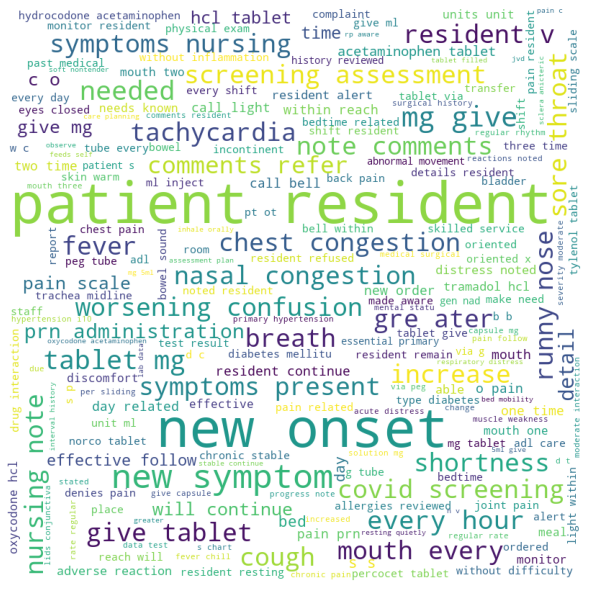

In [22]:
generate_wordcloud(transfered_notes)

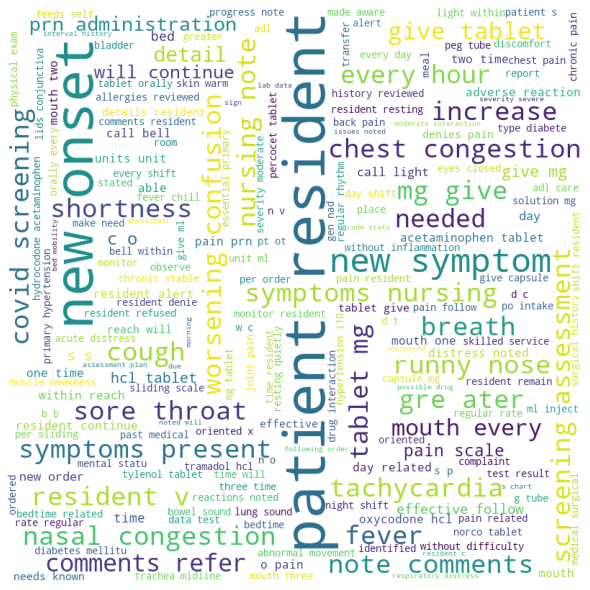

In [24]:
generate_wordcloud(safe_notes)